### Configs

In [1]:
colab = 1

lr_OD = 0.005
lr_DD = 0.01

convert2png = 0

num_classes = 894

num_epochs = 50

load_model = 1
save_model = 1

if colab==0:
    root_folder = "Datas"
    OD_model_save_dir = "Models/ODModel.pth.tar"
    DD_model_save_dir = "Models/DDModel.pth.tar"

    OD_logs_path = "Logs/ODLogs.txt"
    DD_logs_path = "Logs/DDLogs.txt"
else:
    root_folder = "/content/drive/My Drive/Courses/DeepLearning/Project/Datas"
    
    OD_model_save_dir = "/content/drive/My Drive/Courses/DeepLearning/Project/Models/ODModel.pth.tar"    
    DD_model_save_dir = "/content/drive/My Drive/Courses/DeepLearning/Project/Models/DDModel.pth.tar"

    OD_logs_path = "/content/drive/My Drive/Courses/DeepLearning/Project/Logs/ODLogs.txt"
    DD_logs_path = "/content/drive/My Drive/Courses/DeepLearning/Project/Logs/DDLogs.txt"

### Imports

In [2]:
if colab:
    !pip install mat73
    !pip install timm
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.append("/content/drive/My Drive/Courses/DeepLearning/Project")

## Python Files

import utils
import datas
import models
from engine import train_one_epoch_OD, train_one_epoch_DD, evaluate
import transforms as T

## Libraries
import os  # when loading file paths
import numpy as np
from PIL import Image  # Load img
import torch
import torch.nn as nn
import statistics
import torchvision
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import mat73
import cv2 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Setting up GPU Device

In [3]:
# Setting device on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


### Convert .mat to .png images for memory managment during training

In [6]:
if convert2png:
    path2dataset = "nyu_depth_v2_labeled.mat"
    utils.mat2png(path2dataset)

### Load datas

In [4]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


transform = get_transform(train=True)

train_loader, test_loader = datas.get_loader(root_folder, batch_size=4, num_datas=1449, train_test_ratio=0.9, transform=transform)

In [5]:
images, depths, targets = next(iter(train_loader))

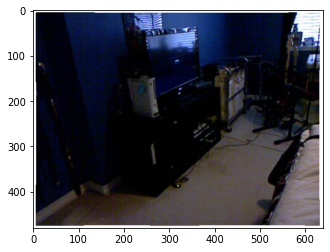

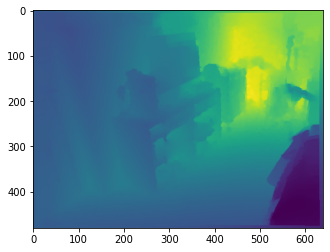

In [6]:
plt.imshow(images[2].permute(1,2,0).cpu().numpy())
plt.figure()
plt.imshow(depths[2].permute(1,2,0).cpu().numpy())

### Training  - Object Detector

In [5]:
object_detector = models.ObjectDetector(num_classes=num_classes).to(device)
criterion = nn.MSELoss().to(device)
params = [p for p in object_detector.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr_OD,
                            momentum=0.9, weight_decay=0.0005)

In [6]:
if load_model:
      utils.load_checkpoint(torch.load(OD_model_save_dir), object_detector, optimizer)

for epoch in range(num_epochs):
    logs = train_one_epoch_OD(object_detector, optimizer, train_loader, device, epoch, print_freq=5, logs_path=OD_logs_path)
    evaluate(object_detector, test_loader, device=device)
    if save_model:
        checkpoint = {
            "state_dict": object_detector.state_dict(),
            "optimizer": optimizer.state_dict(),
            }
        utils.save_checkpoint(checkpoint, filename=OD_model_save_dir)

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/326]  eta: 12:03:13  lr: 0.000020  loss: 9.4459 (9.4459)  loss_classifier: 7.2719 (7.2719)  loss_box_reg: 0.9410 (0.9410)  loss_mask: 0.7088 (0.7088)  loss_objectness: 0.3892 (0.3892)  loss_rpn_box_reg: 0.1350 (0.1350)  time: 133.1084  data: 4.0154


KeyboardInterrupt: ignored

In [ ]:
# pick one image from the test set
images, depths, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
img = images[3]
# put the model in evaluation mode
object_detector.eval()
with torch.no_grad():
    prediction = object_detector([img.to(device)])
    
plt.imshow(img.permute(1,2,0).cpu().numpy())

[{'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([]),
  'masks': tensor([], size=(0, 1, 480, 640))}]

In [ ]:
plot_img = 0
for obj in range(15):
  plot_img = plot_img + prediction[0]['masks'][obj, 0].mul(255)
plt.imshow(plot_img.cpu().numpy())

### Training - Depth Estimation

In [7]:
model_type = "DPT_Hybrid"
depth_estimator = models.DepthEstimation(model_type)

depth_estimator.to(device)
criterion = nn.MSELoss().to(device)
params = [p for p in depth_estimator.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr_DD,
                            momentum=0.9, weight_decay=0.0005)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
if load_model:
      utils.load_checkpoint(torch.load(DD_model_save_dir), depth_estimator, optimizer)

for epoch in range(num_epochs):
  train_one_epoch_DD(depth_estimator, optimizer, criterion, train_loader, device, epoch, print_freq=20, logs_path=DD_logs_path)

  if save_model:
        checkpoint = {
            "state_dict": depth_estimator.state_dict(),
            "optimizer": optimizer.state_dict(),
            }
        utils.save_checkpoint(checkpoint, filename=DD_model_save_dir)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Epoch = 0 | Itter =  0/326 | Loss = 0.038667261600494385
Epoch = 0 | Itter =  20/326 | Loss = 0.029250210151076317
Epoch = 0 | Itter =  40/326 | Loss = 0.0387481190264225
Epoch = 0 | Itter =  60/326 | Loss = 0.022860687226057053
Epoch = 0 | Itter =  80/326 | Loss = 0.02074938267469406
Epoch = 0 | Itter =  100/326 | Loss = 0.015900446102023125
Epoch = 0 | Itter =  120/326 | Loss = 0.054567184299230576
Epoch = 0 | Itter =  140/326 | Loss = 0.014707873575389385
Epoch = 0 | Itter =  160/326 | Loss = 0.020081903785467148
Epoch = 0 | Itter =  180/326 | Loss = 0.02010703831911087
Epoch = 0 | Itter =  200/326 | Loss = 0.010454009287059307
Epoch = 0 | Itter =  220/326 | Loss = 0.01737237349152565
Epoch = 0 | Itter =  240/326 | Loss = 0.010662175714969635
Epoch = 0 | Itter =  260/326 | Loss = 0.01101547572761774
Epoch = 0 | Itter =  280/326 | Loss = 0.01613904908299446
Epoch = 0 | Itter =  300/326 | Loss = 0.010068812407553196
Epoch = 0 | Itter =  320/326 | Loss = 0.025859301909804344
=> Saving 